In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [3]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT, save_figure
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_replay_info_95.csv")
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

for state in STATE_ORDER:
    replay_info[f"{state}_pct_unique_spiking"] = (
        replay_info[f"{state}_n_unique_spiking"] / replay_info["n_tetrodes"]
    )
replay_info = replay_info.rename(index={"Cor": "cor"}).rename_axis(
    index={"animal": "Animal ID"}
)
replay_info.head()

Continuous  Continuous_duration  \
Animal ID day epoch ripple_number                                    
cor       1   2     1                   False                0.000   
                    2                   False                0.000   
                    3                   False                0.000   
                    4                    True                0.054   
                    5                   False                0.000   

                                   Continuous_max_probability  \
Animal ID day epoch ripple_number                               
cor       1   2     1                                0.433000   
                    2                                0.145381   
                    3                                0.253176   
                    4                                0.984090   
                    5                                0.471484   

                                   Continuous_max_time  Continuous_min_time  \
Animal ID day epoch ripple_number                                             
cor       1   2     1                              NaN                  NaN   
                    2                              NaN                  NaN   
                    3                              NaN                  NaN   
                    4                            0.064                0.012   
                    5                              NaN                  NaN   

                                   Continuous_n_total_spikes  \
Animal ID day epoch ripple_number                              
cor       1   2     1                                    NaN   
                    2                                    NaN   
                    3                                    NaN   
                    4                                   78.0   
                    5                                    NaN   

                                   Continuous_n_unique_spiking  \
Animal ID day epoch ripple_number                                
cor       1   2     1                                      NaN   
                    2                                      NaN   
                    3                                      NaN   
                    4                                      9.0   
                    5                                      NaN   

                                   Continuous_population_rate  \
Animal ID day epoch ripple_number                               
cor       1   2     1                                     NaN   
                    2                                     NaN   
                    3                                     NaN   
                    4                              131.313131   
                    5                                     NaN   

                                   Continuous_replay_distance_from_actual_position  \
Animal ID day epoch ripple_number                                                    
cor       1   2     1                                                          NaN   
                    2                                                          NaN   
                    3                                                          NaN   
                    4                                                     23.66645   
                    5                                                          NaN   

                                   Continuous_replay_distance_from_center_well  \
Animal ID day epoch ripple_number                                                
cor       1   2     1                                                      NaN   
                    2                                                      NaN   
                    3                                                      NaN   
                    4                                                 23.66645   
                    5                                                  

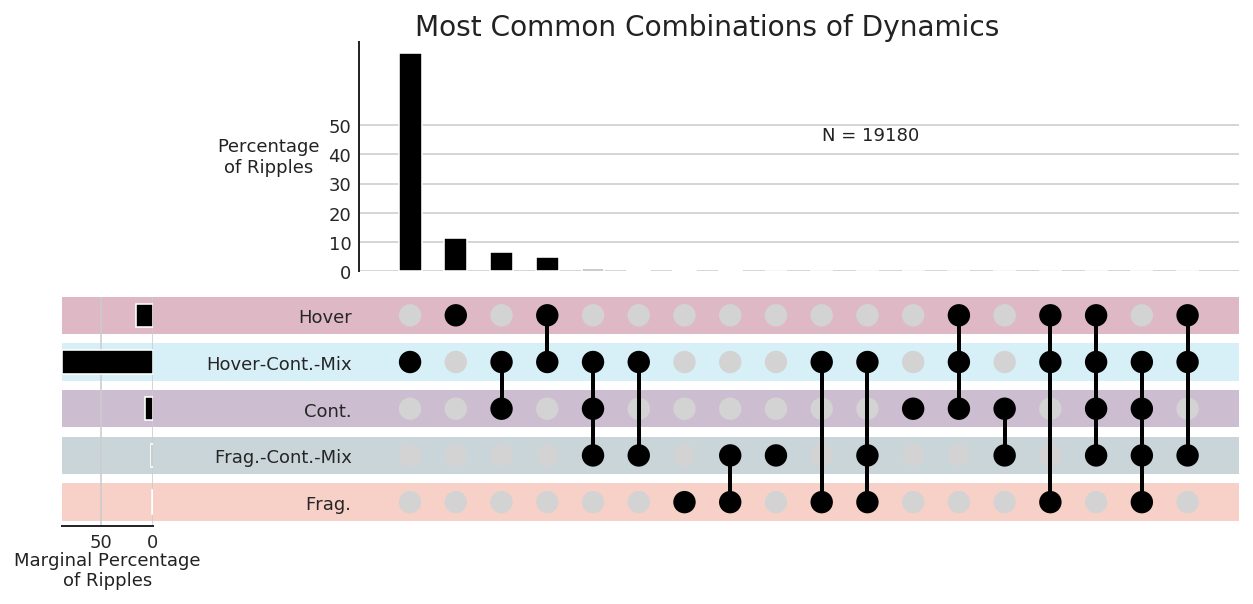

In [4]:
from src.visualization import SHORT_STATE_NAMES
from src.parameters import SHORT_STATE_ORDER, STATE_ORDER
from upsetplot import UpSet


def plot_category_counts(replay_info):
    df = replay_info.rename(columns=SHORT_STATE_NAMES).set_index(
        SHORT_STATE_ORDER[::-1]
    )
    upset = UpSet(
        df,
        sort_sets_by=None,
        show_counts=False,
        subset_size="count",
        sort_by="cardinality",
        intersection_plot_elements=5,
    )
    ax_dict = upset.plot()
    n_classified = replay_info.is_classified.sum()
    _, intersect_max = ax_dict["intersections"].get_ylim()
    ax_dict["intersections"].set_yticks(n_classified * np.arange(0, 0.6, 0.1))
    ax_dict["intersections"].set_yticklabels(range(0, 60, 10))
    ax_dict["intersections"].set_ylabel(
        "Percentage\nof Ripples",
        ha="center",
        va="center",
        rotation="horizontal",
        labelpad=30,
    )
    ax_dict["intersections"].text(
        9, n_classified * 0.45, f"N = {n_classified}", zorder=1000, fontsize=9
    )

    ax_dict["totals"].set_xticks([0, 0.5 * n_classified])
    ax_dict["totals"].set_xticklabels([0, 50])
    ax_dict["totals"].set_xlabel("Marginal Percentage\nof Ripples")
    ax_dict["totals"].set_ylim([-0.5, 4.4])

    plt.suptitle("Most Common Combinations of Dynamics", fontsize=14, x=0.55, y=0.925)
    for i, color in enumerate(STATE_ORDER):
        rect = plt.Rectangle(
            xy=(0, len(STATE_ORDER) - i - 1.4),
            width=1,
            height=0.8,
            facecolor=STATE_COLORS[color],
            lw=0,
            zorder=0,
            alpha=0.25,
        )
        ax_dict["shading"].add_patch(rect)

    return ax_dict


ax_dict = plot_category_counts(replay_info.loc[replay_info.is_classified])

In [5]:
classified_replay_info = replay_info.loc[replay_info.is_classified]
n_states = classified_replay_info.loc[:, STATE_ORDER].sum(axis=1)

print(
    f"Number of single dynamic: {(n_states == 1).sum()} / {len(classified_replay_info)} or {(n_states == 1).mean() * 100:0.0f}%\n"
    f"Number of multiple dynamics: {(n_states > 1).sum()} / {len(classified_replay_info)} or {(n_states > 1).mean() * 100:0.0f}%\n"
    f"Number of >2 dynamics: {(n_states > 2).sum()} / {len(classified_replay_info)} or {(n_states > 2).mean() * 100:0.0f}%\n"
)

Number of single dynamic: 16617 / 19180 or 87%
Number of multiple dynamics: 2563 / 19180 or 13%
Number of >2 dynamics: 220 / 19180 or 1%



In [6]:
num = (classified_replay_info["Hover-Continuous-Mix"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(
    f"Number of Only Stationary-Continuous-Mix: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of Only Stationary-Continuous-Mix: 14309 / 19180 or 75%



In [7]:
is_scm = classified_replay_info["Hover-Continuous-Mix"] & (n_states == 1)
scm_duration = classified_replay_info.loc[is_scm].duration.median() * 1000
scm_distance_from_animal = classified_replay_info.loc[
    is_scm
].replay_distance_from_actual_position.median()

print(f"Only Stationary-Continuous-Mix duration: {scm_duration:0.0f} ms")
print(
    f"Only Stationary-Continuous-Mix distance from animal: {scm_distance_from_animal:0.0f} cm"
)

Only Stationary-Continuous-Mix duration: 75 ms
Only Stationary-Continuous-Mix distance from animal: 34 cm


In [8]:
is_continuous = classified_replay_info["Continuous"]
continuous_duration = classified_replay_info.loc[is_continuous].duration.median() * 1000
continuous_distance_from_animal = classified_replay_info.loc[
    is_continuous
].replay_distance_from_actual_position.median()

print(f"continuous duration: {continuous_duration:0.0f} ms")
print(f"continuous distance from animal: {continuous_distance_from_animal:0.0f} cm")

continuous duration: 111 ms
continuous distance from animal: 45 cm


In [9]:
num = (classified_replay_info["Hover"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(f"Number of Only Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Only Stationary: 2174 / 19180 or 11%



In [10]:
num = (classified_replay_info["Fragmented"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(f"Number of Only Fragmented: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Only Fragmented: 60 / 19180 or 0%



In [11]:
has_short_duration_jump = (
    (
        classified_replay_info["Fragmented"]
        | classified_replay_info["Fragmented-Continuous-Mix"]
    )
    & (
        classified_replay_info["Hover"]
        | classified_replay_info["Hover-Continuous-Mix"]
        | classified_replay_info["Continuous"]
    )
    & (
        (classified_replay_info["Fragmented_duration"] < 0.010)
        | (classified_replay_info["Fragmented-Continuous-Mix_duration"] < 0.010)
    )
)
num = has_short_duration_jump.sum()
denom = len(classified_replay_info)

print(f"Number of short duration jump: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of short duration jump: 319 / 19180 or 2%



In [12]:
has_spatially_coherent_and_incoherent = (
    classified_replay_info["Fragmented"]
    | classified_replay_info["Fragmented-Continuous-Mix"]
) & (
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)
num = has_spatially_coherent_and_incoherent.sum()
denom = len(classified_replay_info)

print(
    f"Number of spatially coherent and incoherent: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of spatially coherent and incoherent: 324 / 19180 or 2%



Text(0.5, 0, 'Duration of Fragmented with spatially coherent [ms]')

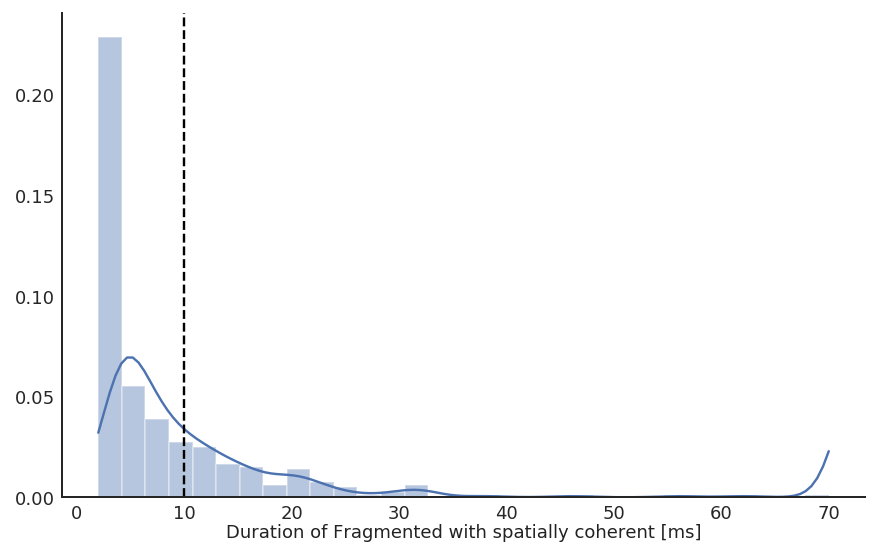

In [13]:
spatially_coherent_and_incoherent_replay_info = classified_replay_info.loc[
    has_spatially_coherent_and_incoherent
]
duration_spatially_coherent_and_incoherent_replay = (
    pd.concat(
        (
            spatially_coherent_and_incoherent_replay_info.loc[
                spatially_coherent_and_incoherent_replay_info["Fragmented"],
                "Fragmented_duration",
            ],
            spatially_coherent_and_incoherent_replay_info.loc[
                spatially_coherent_and_incoherent_replay_info[
                    "Fragmented-Continuous-Mix"
                ],
                "Fragmented-Continuous-Mix_duration",
            ],
        )
    )
    * 1000
).to_numpy()

sns.distplot(duration_spatially_coherent_and_incoherent_replay, kde_kws=dict(cut=0))
plt.axvline(10, color="black", linestyle="--")
sns.despine()
plt.xlabel("Duration of Fragmented with spatially coherent [ms]")

In [14]:
has_no_spatially_coherent_and_incoherent = (
    classified_replay_info["Fragmented"]
    | classified_replay_info["Fragmented-Continuous-Mix"]
) & ~(
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)

num = has_no_spatially_coherent_and_incoherent.sum()
denom = len(classified_replay_info)

print(
    f"Number of not spatially coherent and incoherent: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of not spatially coherent and incoherent: 160 / 19180 or 1%



Text(0.5, 1.0, 'Multiunit Population Rate')

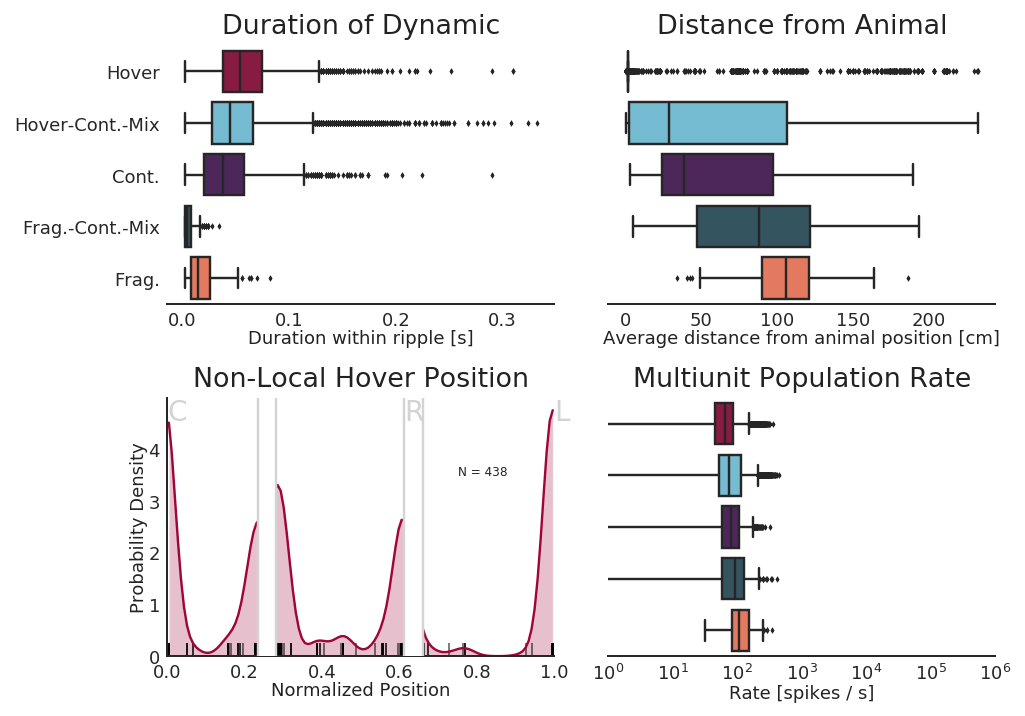

In [15]:
from src.visualization import (
    plot_replay_distance_from_actual_position,
    plot_category_duration,
    plot_linear_position_markers,
    plot_population_rate,
    _plot_category,
)

saturation, fliersize = 0.7, 1

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(TWO_COLUMN, PAGE_HEIGHT / 2), constrained_layout=True
)

# Duration of Dynamic
plot_category_duration(
    replay_info, kind="box", ax=axes[0, 0], fliersize=fliersize, saturation=saturation,
)
axes[0, 0].set_title("Duration of Dynamic")

# Distance from Animal
plot_replay_distance_from_actual_position(
    replay_info, kind="box", ax=axes[0, 1], fliersize=fliersize, saturation=saturation
)
axes[0, 1].set_title("Distance from Animal")
axes[0, 1].set_yticklabels([])

# Non-Local Hover Position
norm_non_local_hover = (
    replay_info.loc[
        replay_info.Hover_replay_distance_from_actual_position > 30
    ].Hover_replay_linear_position.values
    / replay_info.loc[
        replay_info.Hover_replay_distance_from_actual_position > 30
    ].left_well_position
)

sns.distplot(
    norm_non_local_hover,
    kde_kws=dict(
        bw=0.025, cut=0, shade=True, facecolor=STATE_COLORS["Hover"], legend=False,
    ),
    rug_kws=dict(color="black", alpha=0.5),
    kde=True,
    rug=True,
    hist=False,
    color=STATE_COLORS["Hover"],
    ax=axes[1, 0],
)
axes[1, 0].set_xlabel("Normalized Position")
axes[1, 0].set_ylabel("Probability Density")
plot_linear_position_markers(
    replay_info,
    is_normalized=True,
    jitter=0.00,
    zorder=101,
    alpha=1,
    ax=axes[1, 0],
    linestyle="-",
    fontsize=14,
)

sns.despine(ax=axes[1, 0])
axes[1, 0].set_xlim((0, 1))
axes[1, 0].set_title("Non-Local Hover Position")
n_non_local = norm_non_local_hover.size
axes[1, 0].text(0.75, 3.5, f"N = {n_non_local}", zorder=100, fontsize=6)

# Population firing rate
_plot_category(
    replay_info,
    "population_rate",
    kind="box",
    ax=axes[1, 1],
    fliersize=fliersize,
    saturation=saturation,
)
axes[1, 1].set_yticklabels([])
axes[1, 1].set_xscale("log")
axes[1, 1].set_xlim((1e0, 1e6))
axes[1, 1].set_xlabel("Rate [spikes / s]")
axes[1, 1].set_title("Multiunit Population Rate")

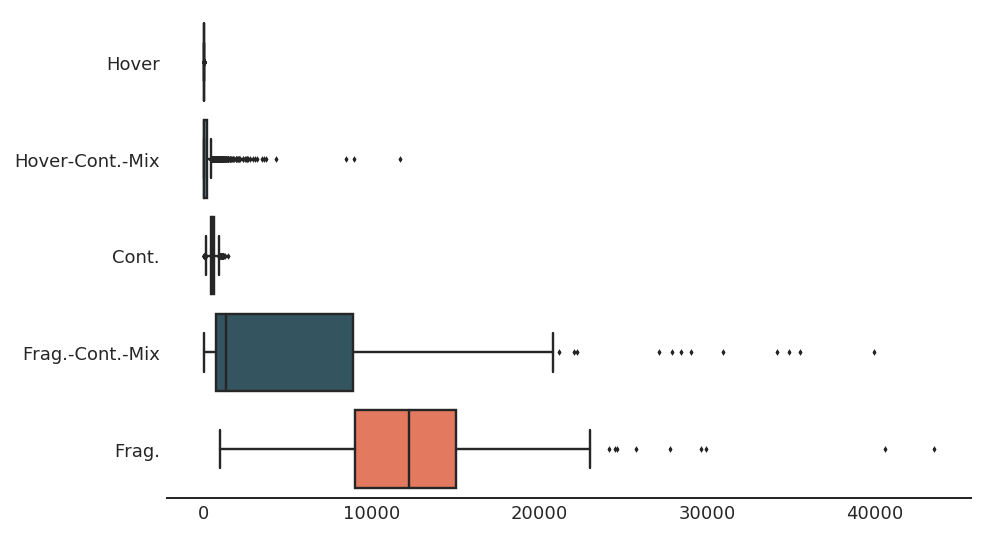

In [16]:
_plot_category(
    replay_info, "replay_speed", kind="box", fliersize=fliersize, saturation=saturation,
)

In [17]:
replay_info.loc[replay_info.loc[:, "Hover_replay_speed"] > 30].Hover_replay_speed

Animal ID  day  epoch  ripple_number
fra        5    4      212              44.086814
Name: Hover_replay_speed, dtype: float64

In [18]:
num = ((replay_info.Hover_replay_distance_from_actual_position > 30)).sum()
denom = len(classified_replay_info)

print(f"Number of Non-Local Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Non-Local Stationary: 438 / 19180 or 2%



In [19]:
num = (
    (replay_info.Hover_replay_distance_from_actual_position > 30) & (n_states == 1)
).sum()
denom = ((replay_info.Hover_replay_distance_from_actual_position > 30)).sum()

print(f"Number of Non-Local Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Non-Local Stationary: 181 / 438 or 41%



In [20]:
f"{replay_info.Hover_replay_distance_from_actual_position.max():0.0f}"

'232'

In [21]:
with pd.option_context("display.max_rows", 1000):
    display(classified_replay_info.state_order.value_counts())

['Hover-Continuous-Mix']                                                                                                                                                                       14199
['Hover']                                                                                                                                                                                       2197
['Hover-Continuous-Mix', 'Continuous', 'Hover-Continuous-Mix']                                                                                                                                   723
['Hover', 'Hover-Continuous-Mix']                                                                                                                                                                429
['Continuous', 'Hover-Continuous-Mix']                                                                                                                                                           334
['Hover-Continu

(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  3.,  0.,  1.,  1.,  1.,
         2.,  0.,  0.,  4.,  0.,  0.,  5.,  0.,  1.,  1.,  1.,  1.,  3.,
         1.,  1.,  1.,  0.,  4.,  1.,  3.,  5.,  1.,  4.,  1.,  5.,  1.,
         3.,  3.,  0.,  2.,  2.,  4.,  1.,  0.,  1.,  4.,  1.,  2.,  1.,
        21.,  1.,  1.,  0.,  0.,  2.,  8.,  5.,  5.,  3.,  1.,  5., 10.,
         5.,  3.,  2.,  7.,  3.,  2.,  1.,  5.,  7.,  2.,  4.,  3.,  7.,
         9.,  7.,  1.,  5.,  3.,  5., 13.,  1.,  2.,  7.,  5.,  5.,  3.,
         6., 11.,  4.,  7.,  8.,  6.,  6.,  3.,  4.

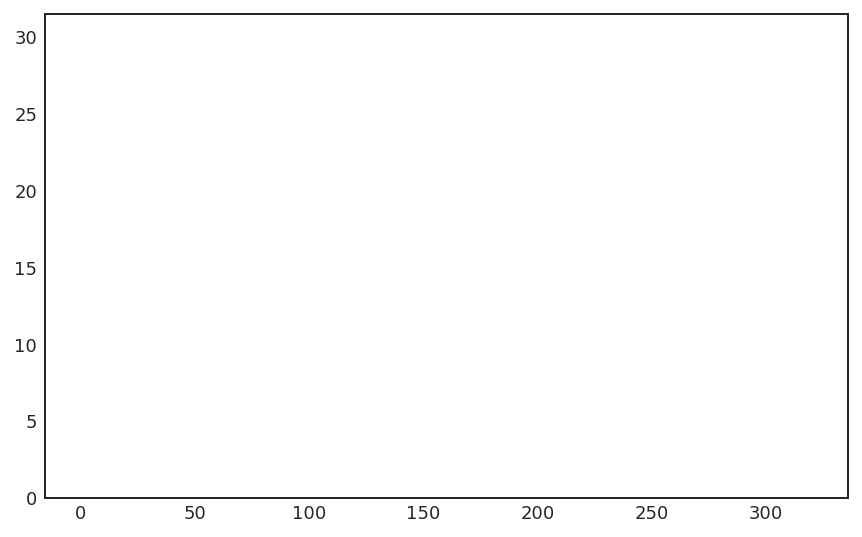

In [22]:
plt.hist(replay_info.Continuous_population_rate.dropna().to_numpy(), bins=1000)

In [23]:
replay_info.loc[replay_info.Continuous_population_rate < 10]

Continuous  Continuous_duration  \
Animal ID day epoch ripple_number                                    
bon       4   2     89                   True                0.004   
          7   4     191                  True                0.002   
fra       10  6     166                  True                0.008   

                                   Continuous_max_probability  \
Animal ID day epoch ripple_number                               
bon       4   2     89                               0.951665   
          7   4     191                              0.954350   
fra       10  6     166                              0.963147   

                                   Continuous_max_time  Continuous_min_time  \
Animal ID day epoch ripple_number                                             
bon       4   2     89                           0.028                0.026   
          7   4     191                          0.050                0.050   
fra       10  6     166                          0.006                0.000   

                                   Continuous_n_total_spikes  \
Animal ID day epoch ripple_number                              
bon       4   2     89                                   0.0   
          7   4     191                                  0.0   
fra       10  6     166                                  0.0   

                                   Continuous_n_unique_spiking  \
Animal ID day epoch ripple_number                                
bon       4   2     89                                     0.0   
          7   4     191                                    0.0   
fra       10  6     166                                    0.0   

                                   Continuous_population_rate  \
Animal ID day epoch ripple_number                               
bon       4   2     89                                    0.0   
          7   4     191                                   0.0   
fra       10  6     166                                   0.0   

                                   Continuous_replay_distance_from_actual_position  \
Animal ID day epoch ripple_number                                                    
bon       4   2     89                                                   11.685414   
          7   4     191                                                  13.027066   
fra       10  6     166                                                  17.970654   

                                   Continuous_replay_distance_from_center_well  \
Animal ID day epoch ripple_number                                                
bon       4   2     89                                              158.917414   
          7   4     191                                             157.654473   
fra       10  6     166                                             160.361885   

                                   ...  spatial_coverage  \
Animal ID day epoch ripple_number  ...                     
bon       4   2     89             ...         21.030336   
          7   4     191            ...         15.124911   
fra       10  6     166            ...         21.728598   

                                   spatial_coverage_percentage  \
Animal ID day epoch ripple_number                                
bon       4   2     89                                0.076246   
          7   4     191                               0.056245   
fra       10  6     166                               0.074708   

                                                  start_time  \
Animal ID day epoch ripple_number                              
bon       4   2     89             0 days 00:48:19.000133333   
          7   4     191            0 days 01:21:56.969200000   
fra       10  6     166            0 days 02:10:23.643200000   

                                                                         state_order  \
Animal ID day epoch ripple_number                                                      
bon       4  